In [21]:
import torch
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics.functional import multiclass_accuracy
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd

Setting up file paths and some other things for converting image data to tensors.

In [2]:
training_path ='./archive/Train Images 13440x32x32/train/'
test_path ='./archive/Test Images 3360x32x32/test/'


train_files=os.listdir(training_path)
test_files=os.listdir(test_path)
transform=transforms.Compose([transforms.ToTensor()])


In [3]:
def data_builder(path, files):
    '''Function for converting image data to tensors for using in training, along with getting the labels
       from the file name.
    '''
    img_fordim=cv2.imread(os.path.join(path,files[0]), 0)
    image_size=torch.flatten(transform(img_fordim))
    dim1=image_size.shape[0]
    dim0=len(files)
    data=torch.zeros((dim0, dim1))
    labels=torch.zeros((dim0, 1))
    for i, file in enumerate(files):
        img=cv2.imread(os.path.join(path,file), 0)
        flat_tens=torch.flatten(transform(img))
        data[i]=flat_tens
        label=file.split('_')[-1][:2]
        labels[i]=float(label)-1
        
    return data, labels

In [4]:
device= 'cuda' if torch.cuda.is_available() else "cpu"

device

'cpu'

In [5]:
test_data, test_labels = data_builder(test_path, test_files)

train_data, train_labels = data_builder(training_path, train_files)


In [56]:
torch.save(test_data, 'test_data.pt')
torch.save(test_labels, 'test_labels.pt')
torch.save(train_data, 'train_data.pt')
torch.save(train_labels, 'train_labels.pt')

In [6]:
class ArabicCharClassifier(nn.Module):
    def __init__(self, n_char):
        super().__init__()
        self.hidden1=nn.Linear(1024, 100)
        self.hidden2=nn.Linear(100, 100)
        self.hidden3=nn.Linear(100,100)
        self.hidden4=nn.Linear(100,100)
        self.hidden5=nn.Linear(100,100)
        self.hiddenfin=nn.Linear(100, n_char)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout()
        self.batch1=nn.BatchNorm1d(100)
        self.batch2=nn.BatchNorm1d(100)
        self.batch3=nn.BatchNorm1d(100)
        self.batch4=nn.BatchNorm1d(100)
        self.batch5=nn.BatchNorm1d(100)
        
    def forward(self, x):
        X = self.hidden1(x)
        X = self.relu(X)
        X = self.batch1(X)
        X = self.dropout(X)
        
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.batch2(X)
        X = self.dropout(X)
        
        X = self.hidden3(X)
        X = self.relu(X)
        X = self.batch3(X)
        X = self.dropout(X)
        
        X = self.hidden4(X)
        X = self.relu(X)
        X = self.batch4(X)
        X = self.dropout(X)
        
        X = self.hidden5(X)
        X = self.relu(X)
        X = self.batch5(X)
        X = self.dropout(X)
        
        
        
        X = self.hiddenfin(X)
        
        return X
    

In [7]:
model=ArabicCharClassifier(n_char=28).to(device)
model

ArabicCharClassifier(
  (hidden1): Linear(in_features=1024, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (hidden4): Linear(in_features=100, out_features=100, bias=True)
  (hidden5): Linear(in_features=100, out_features=100, bias=True)
  (hiddenfin): Linear(in_features=100, out_features=28, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [8]:
loss = nn.CrossEntropyLoss()

optimization = optim.Adam(params=model.parameters(), lr=0.001)

In [9]:
def metrics(y_pred, y_true, num_char):
    acc = multiclass_accuracy(y_pred, y_true)
    f1_score = multiclass_f1_score(y_pred, y_true, num_classes=num_char)
    return f1_score, acc 

In [10]:
num_epoch = 200

train_data, train_labels = train_data.to(device), train_labels.to(device)

test_data, test_labels = test_data.to(device), test_labels.to(device)

train_metrics={'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

test_metrics = {'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

for epoch in range(num_epoch):
    
    train_pred=model(train_data)
    model.train()
    
    
    
    y_train = torch.squeeze(train_labels).type(torch.LongTensor) 
    
    optimization.zero_grad()
    
    loss_epoch = loss(train_pred, y_train)
    
    f1_train, acc_train = metrics(train_pred, y_train, 28)
    
    loss_epoch.backward()
    
    optimization.step()
    
    train_metrics['loss'].append(loss_epoch.item())
    train_metrics['accuracy'].append(acc_train.item()*100)
    train_metrics['f1_score'].append(f1_train.item())
    
    model.eval()
    with torch.inference_mode():
        test_pred = model(test_data)
        y_eval = torch.squeeze(test_labels).type(torch.LongTensor) 
        loss_eval=loss(test_pred, y_eval)
        f1_test, acc_test = metrics(test_pred, torch.squeeze(test_labels), 28)
        
        test_metrics['accuracy'].append(acc_test.item()*100)
        test_metrics['f1_score'].append(f1_test.item())
        test_metrics['loss'].append(loss_eval.item())
        
        
    if epoch%10==0:
        print(f'Epoch: {epoch} | Train loss: {loss_epoch:.5f} | Train accuracy: {acc_train*100:.3f}% | Train f1 {f1_train:.3f} | Test accuracy {acc_test*100:.3f}% | Test f1 {f1_test:.3f}')
        
        
    

Epoch: 0 | Train loss: 3.64782 | Train accuracy: 3.438% | Train f1 0.034 | Test accuracy 3.571% | Test f1 0.036
Epoch: 10 | Train loss: 3.33226 | Train accuracy: 3.333% | Train f1 0.033 | Test accuracy 3.036% | Test f1 0.030
Epoch: 20 | Train loss: 3.32742 | Train accuracy: 5.164% | Train f1 0.052 | Test accuracy 5.357% | Test f1 0.054
Epoch: 30 | Train loss: 3.30582 | Train accuracy: 7.560% | Train f1 0.076 | Test accuracy 7.381% | Test f1 0.074
Epoch: 40 | Train loss: 3.16806 | Train accuracy: 6.741% | Train f1 0.067 | Test accuracy 6.577% | Test f1 0.066
Epoch: 50 | Train loss: 2.99961 | Train accuracy: 12.426% | Train f1 0.124 | Test accuracy 9.792% | Test f1 0.098
Epoch: 60 | Train loss: 2.75035 | Train accuracy: 15.766% | Train f1 0.158 | Test accuracy 15.506% | Test f1 0.155
Epoch: 70 | Train loss: 2.41819 | Train accuracy: 20.908% | Train f1 0.209 | Test accuracy 20.506% | Test f1 0.205
Epoch: 80 | Train loss: 2.20991 | Train accuracy: 26.585% | Train f1 0.266 | Test accuracy 2

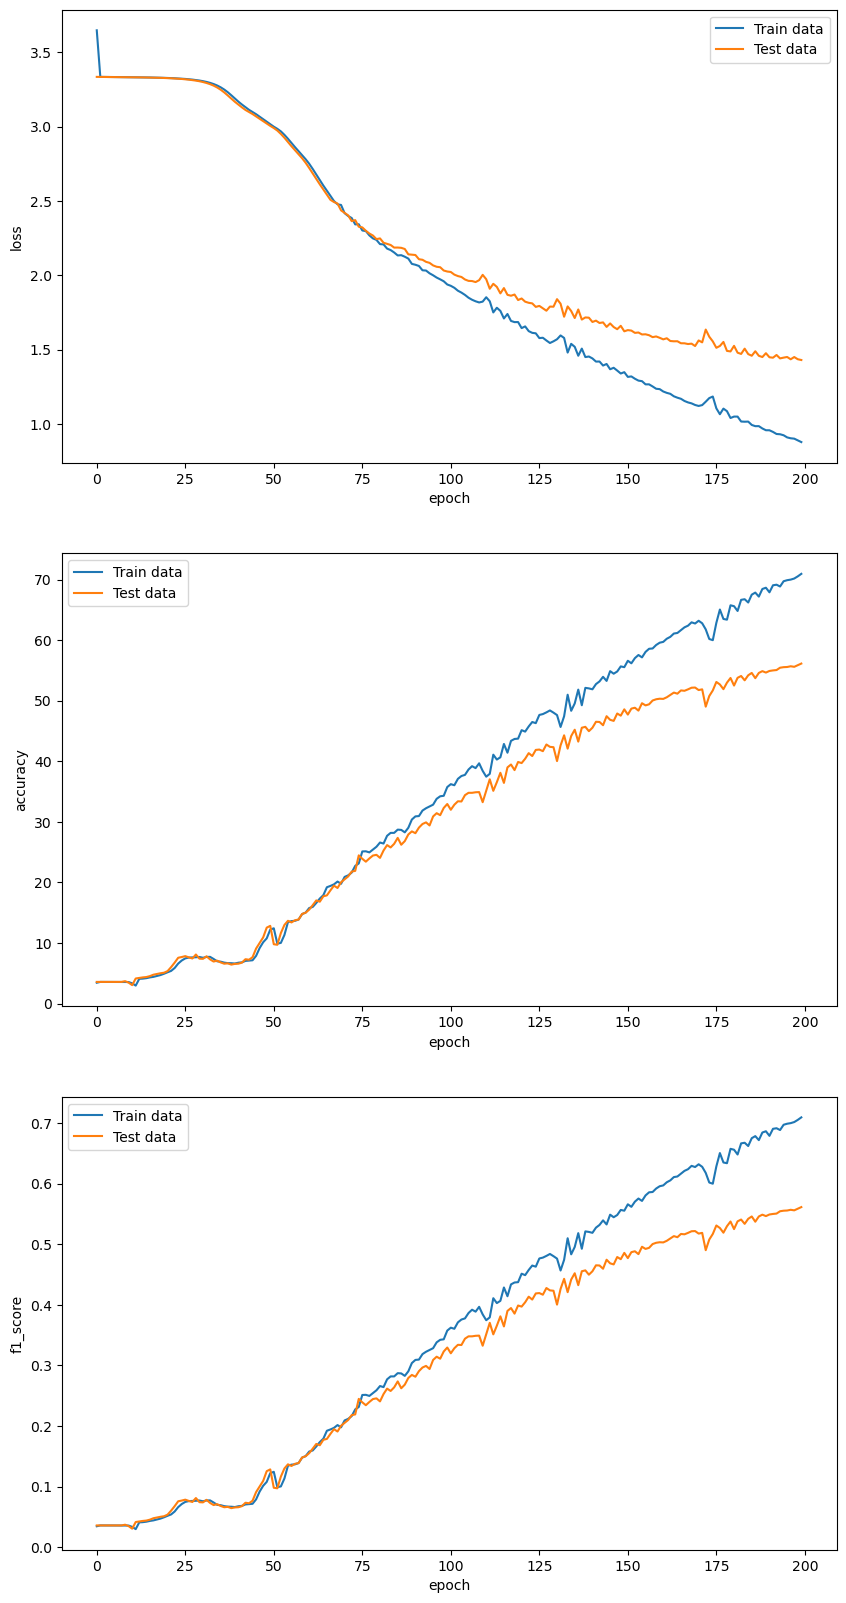

In [11]:
fig, axs = plt.subplots(3, figsize=(10,20))
sns.lineplot(data=train_metrics, x='epoch', y='loss', label='Train data', ax=axs[0])
sns.lineplot(data=test_metrics, x='epoch', y='loss', label='Test data', ax=axs[0])
sns.lineplot(data=train_metrics, x='epoch', y='accuracy', label='Train data', ax=axs[1])
sns.lineplot(data=test_metrics, x='epoch', y='accuracy', label='Test data', ax=axs[1])
sns.lineplot(data=train_metrics, x='epoch', y='f1_score', label='Train data', ax=axs[2])
sns.lineplot(data=test_metrics, x='epoch', y='f1_score', label='Test data', ax=axs[2])
plt.legend()

In [12]:
class ModularNN(nn.Module):
    def __init__(self, n_char, input_size, neurons, depth, add_Dropout=True):
        super().__init__()
        self.layers=nn.ModuleList()
        self.input_layer=nn.Linear(input_size, neurons)
        for i in range(depth):
            self.layers.append(nn.Linear(neurons, neurons))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(neurons))
            if add_Dropout:
                self.layers.append(nn.Dropout())
        self.final_layer=nn.Linear(neurons, n_char)

    def forward(self, X):
        x=self.input_layer(X)
        for layer in self.layers:
            x=layer(x)
        x=self.final_layer(x)
        
        return x
            

In [13]:
model_2=ModularNN(n_char=28, input_size=1024, neurons=100, depth=5).to(device)
model_2

ModularNN(
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=100, out_features=100, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(100, eps=1e-05, momentum=0.1,

In [14]:
def SingleTrain(layer_size, depth, num_epochs, learning_rate, printing = False, train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, loss=nn.CrossEntropyLoss()):
    model=model_2=ModularNN(n_char=28, input_size=1024, neurons=layer_size, depth=depth).to(device)
    loss=loss
    optimization= optim.Adam(params=model.parameters(), lr=learning_rate)

    train_metrics={'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    test_metrics = {'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    for epoch in range(num_epochs):
    
        train_pred=model(train_data)
        model.train()
        
        y_train = torch.squeeze(train_labels).type(torch.LongTensor) 
        
        optimization.zero_grad()
        
        loss_epoch = loss(train_pred, y_train)
        
        f1_train, acc_train = metrics(train_pred, y_train, 28)
        
        loss_epoch.backward()
        
        optimization.step()
        
        train_metrics['loss'].append(loss_epoch.item())
        train_metrics['accuracy'].append(acc_train.item()*100)
        train_metrics['f1_score'].append(f1_train.item())
    
        model.eval()
        with torch.inference_mode():
            test_pred = model(test_data)
            y_eval = torch.squeeze(test_labels).type(torch.LongTensor) 
            loss_eval=loss(test_pred, y_eval)
            f1_test, acc_test = metrics(test_pred, torch.squeeze(test_labels), 28)
            
            test_metrics['accuracy'].append(acc_test.item()*100)
            test_metrics['f1_score'].append(f1_test.item())
            test_metrics['loss'].append(loss_eval.item())

        if printing:
            if epoch%10==0:
                print(f'Epoch: {epoch} | Train loss: {loss_epoch:.5f} | Train accuracy: {acc_train*100:.3f}% | Train f1 {f1_train:.3f} | Test accuracy {acc_test*100:.3f}% | Test f1 {f1_test:.3f}')
            

    return train_metrics, test_metrics

    

In [15]:
depths=[1,2,3,4]
layer_sizes=[30, 40, 50, 60, 70, 80, 90, 100, 110]

ran_depths = random.choices(depths, k=10)
ran_sizes = random.choices(layer_sizes, k=10)

In [19]:
training_data=[]
testing_data=[]
parameters={'depth':[], 'size':[]}
k=0
for depth, size in zip(ran_depths, ran_sizes):
    print(depth, size)
    tr_metric, ts_metric = SingleTrain(layer_size=size, depth=depth, num_epochs=200, learning_rate=0.001, printing=True)
    training_data.append(tr_metric)
    testing_data.append(ts_metric)
    #parameters['rate'].append(rate) initially was looking into a range of learning rates, but very quickly found out that 0.001 is a good balance of speed and stability 
    parameters['depth'].append(depth)
    parameters['size'].append(size)
    k+=1
    print(f'{k} down, {10-k} to go')
    print('------------------------')

2 100
Epoch: 0 | Train loss: 3.62018 | Train accuracy: 3.832% | Train f1 0.038 | Test accuracy 4.494% | Test f1 0.045
Epoch: 10 | Train loss: 3.25400 | Train accuracy: 7.917% | Train f1 0.079 | Test accuracy 8.065% | Test f1 0.081
Epoch: 20 | Train loss: 3.01981 | Train accuracy: 11.763% | Train f1 0.118 | Test accuracy 13.185% | Test f1 0.132
Epoch: 30 | Train loss: 2.68396 | Train accuracy: 22.359% | Train f1 0.224 | Test accuracy 22.560% | Test f1 0.226
Epoch: 40 | Train loss: 2.37383 | Train accuracy: 30.000% | Train f1 0.300 | Test accuracy 28.958% | Test f1 0.290
Epoch: 50 | Train loss: 2.16980 | Train accuracy: 37.217% | Train f1 0.372 | Test accuracy 35.387% | Test f1 0.354
Epoch: 60 | Train loss: 2.00833 | Train accuracy: 41.615% | Train f1 0.416 | Test accuracy 39.970% | Test f1 0.400
Epoch: 70 | Train loss: 1.85331 | Train accuracy: 46.079% | Train f1 0.461 | Test accuracy 44.315% | Test f1 0.443
Epoch: 80 | Train loss: 1.68233 | Train accuracy: 50.952% | Train f1 0.510 | Te

These simple tests seem to indicate that a good number of layers is between 1 and 3, and a good neuron range seems to be 80-110,
so we can do even more tests in this narrower range, so that we can do some statistics.

In [25]:
depths_2=[1,2,3,]
layer_sizes_2=[80, 90, 100, 110, 120, 130, 140]

ran_depths_2 = random.choices(depths_2, k=100)
ran_sizes_2 = random.choices(layer_sizes_2, k=100)

parameters={'loss_train':[], 'accuracy_train':[], 'f1_score_train':[],'loss_test':[], 'accuracy_test':[], 'f1_score_test':[], 'depth':[], 'size':[]}
k=0
for depth, size in zip(ran_depths_2, ran_sizes_2):
    print(depth, size)
    tr_metric, ts_metric = SingleTrain(layer_size=size, depth=depth, num_epochs=200, learning_rate=0.001, printing=False)
    parameters['loss_train'].append(tr_metric['loss'][-1])
    parameters['loss_test'].append(ts_metric['loss'][-1])
    parameters['accuracy_train'].append(tr_metric['accuracy'][-1])
    parameters['accuracy_test'].append(ts_metric['accuracy'][-1])
    parameters['f1_score_train'].append(tr_metric['f1_score'][-1])
    parameters['f1_score_test'].append(ts_metric['f1_score'][-1])
    parameters['depth'].append(depth)
    parameters['size'].append(size)
    k+=1
    print(f'{k} down, {100-k} to go')
    print('------------------------')

3 120
1 down, 99 to go
------------------------
2 130
2 down, 98 to go
------------------------
3 90
3 down, 97 to go
------------------------
2 130
4 down, 96 to go
------------------------
3 140
5 down, 95 to go
------------------------
1 130
6 down, 94 to go
------------------------
2 120
7 down, 93 to go
------------------------
1 120
8 down, 92 to go
------------------------
2 90
9 down, 91 to go
------------------------
3 140
10 down, 90 to go
------------------------
1 90
11 down, 89 to go
------------------------
1 80
12 down, 88 to go
------------------------
2 90
13 down, 87 to go
------------------------
2 110
14 down, 86 to go
------------------------
3 130
15 down, 85 to go
------------------------
3 140
16 down, 84 to go
------------------------
1 80
17 down, 83 to go
------------------------
2 80
18 down, 82 to go
------------------------
3 140
19 down, 81 to go
------------------------
3 90
20 down, 80 to go
------------------------
3 120
21 down, 79 to go
-------------

In [26]:
parameters_df=pd.DataFrame(parameters)
grouped=parameters_df.groupby(['depth', 'size']).mean()

grouped

loss_train  accuracy_train  f1_score_train  loss_test  \
depth size                                                          
1     80      0.807372       76.034224        0.760342   1.134487   
      90      0.723565       78.759301        0.787593   1.091320   
      100     0.662242       80.818452        0.808185   1.050676   
      110     0.609693       82.252604        0.822526   1.035817   
      120     0.560718       84.118304        0.841183   1.004870   
      130     0.531013       84.967758        0.849678   0.989521   
      140     0.494977       86.081348        0.860813   0.971947   
2     80      0.633368       80.291667        0.802917   1.017931   
      90      0.575019       82.009991        0.820100   0.991742   
      100     0.535855       83.545387        0.835454   0.967788   
      110     0.488660       85.435268        0.854353   0.946837   
      120     0.459148       86.104167        0.861042   0.941678   
      130     0.440642       86.501913        0.865019   0.936520   
      140     0.410822       87.779018        0.877790   0.919148   
3     80      0.709297       76.855159        0.768552   1.064503   
      90      0.684494       77.540923        0.775409   1.059716   
      100     0.634589       79.443824        0.794438   1.018221   
      110     0.571211       81.463295        0.814633   1.007305   
      120     0.557479       81.992559        0.819926   0.983896   
      130     0.534496       82.511904        0.825119   0.996582   
      140     0.517869       83.497024        0.834970   0.972525   

            accuracy_test  f1_score_test  
depth size                                
1     80        65.575397       0.655754  
      90        66.398810       0.663988  
      100       67.311507       0.673115  
      110       67.901786       0.679018  
      120       69.007937       0.690079  
      130       69.379960       0.693800  
      140       70.545636       0.705456  
2     80        68.053572       0.680536  
      90        68.983843       0.689838  
      100       69.910714       0.699107  
      110       70.238096       0.702381  
      120       70.892857       0.708929  
      130       71.262756       0.712628  
      140       72.276786       0.722768  
3     80        66.150794       0.661508  
      90        66.346725       0.663467  
      100       67.823660       0.678237  
      110       69.166668       0.691667  
      120       69.202380       0.692024  
      130       69.035715       0.690357  
      140       69.970238       0.699702

Looking at the result it's at least clear that 2 layers is the way to go, keeping in mind that this means 4 hidden layers total, including the output layer and the input layer. Given that it also seems that the model favours large amounts of neurons, we must be carefull to avoid overfitting, as that would cause more headaches since we would need more data. However knowing a rough area for playing with the overall architecture of the model is a good jumping off point for more fine tunning.

In [32]:
layer_sizes_2=[110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


parameters_2={'loss_train':[], 'accuracy_train':[], 'f1_score_train':[],'loss_test':[], 'accuracy_test':[], 'f1_score_test':[], 'variance_check':[],'size':[]}
k=0
for size in layer_sizes_2:
    tr_metric, ts_metric = SingleTrain(layer_size=size, depth=2, num_epochs=200, learning_rate=0.001, printing=True)
    parameters_2['loss_train'].append(tr_metric['loss'][-1])
    parameters_2['loss_test'].append(ts_metric['loss'][-1])
    parameters_2['accuracy_train'].append(tr_metric['accuracy'][-1])
    parameters_2['accuracy_test'].append(ts_metric['accuracy'][-1])
    parameters_2['f1_score_train'].append(tr_metric['f1_score'][-1])
    parameters_2['f1_score_test'].append(ts_metric['f1_score'][-1])
    parameters_2['variance_check'].append(tr_metric['f1_score'][-1]-ts_metric['f1_score'][-1])
    parameters_2['size'].append(size)
    k+=1
    print(f'{k} down, {len(layer_sizes_2)-k} to go')
    print('------------------------')

Epoch: 0 | Train loss: 3.63684 | Train accuracy: 3.832% | Train f1 0.038 | Test accuracy 4.940% | Test f1 0.049
Epoch: 10 | Train loss: 3.25594 | Train accuracy: 10.900% | Train f1 0.109 | Test accuracy 11.399% | Test f1 0.114
Epoch: 20 | Train loss: 3.01735 | Train accuracy: 11.629% | Train f1 0.116 | Test accuracy 12.946% | Test f1 0.129
Epoch: 30 | Train loss: 2.68869 | Train accuracy: 20.528% | Train f1 0.205 | Test accuracy 20.952% | Test f1 0.210
Epoch: 40 | Train loss: 2.38427 | Train accuracy: 30.260% | Train f1 0.303 | Test accuracy 29.613% | Test f1 0.296
Epoch: 50 | Train loss: 2.16208 | Train accuracy: 37.113% | Train f1 0.371 | Test accuracy 36.012% | Test f1 0.360
Epoch: 60 | Train loss: 1.97586 | Train accuracy: 42.024% | Train f1 0.420 | Test accuracy 40.952% | Test f1 0.410
Epoch: 70 | Train loss: 1.79103 | Train accuracy: 46.830% | Train f1 0.468 | Test accuracy 44.881% | Test f1 0.449
Epoch: 80 | Train loss: 1.59683 | Train accuracy: 51.882% | Train f1 0.519 | Test a

In [33]:
parameters_layer=pd.DataFrame(parameters_2)
parameters_layer

,loss_train,accuracy_train,f1_score_train,loss_test,accuracy_test,f1_score_test,variance_check,size
0,0.486807,85.163689,0.851637,0.959314,70.684522,0.706845,0.144792,110
1,0.499527,84.709823,0.847098,0.968725,70.148808,0.701488,0.145610,120
2,0.460844,86.116070,0.861161,0.932068,71.101189,0.711012,0.150149,130
3,0.413558,87.328869,0.873289,0.939833,70.892859,0.708929,0.164360,140
4,0.392458,88.906252,0.889063,0.914404,72.678572,0.726786,0.162277,150
5,0.374706,88.735121,0.887351,0.911091,72.440475,0.724405,0.162946,160
6,0.362362,89.412200,0.894122,0.904446,72.708333,0.727083,0.167039,170
7,0.340765,90.275300,0.902753,0.907627,72.142857,0.721429,0.181324,180
8,0.321884,90.855652,0.908557,0.900209,73.333335,0.733333,0.175223,190
9,0.296616,91.785717,0.917857,0.877371,73.690474,0.736905,0.180952,200


As can be clearly seen, while the performance might be increasing, the difference in the f1 scores between the training and test set seems to suggest, that overfitting starts to become a greater concern for higher node numbers. Therefore, I'll go with a model with 2 inner hidden layers (so 4 total) and 160 nodes per inner layer. Next is to investigate if changing the sizes of the outer layers would have a noticable effect on the performance.

In [37]:
class TestingTails(nn.Module):
    def __init__(self, n_char, nodes_inner, nodes_outer):
        super().__init__()
        self.inner=nn.Linear(1024, nodes_inner)
        self.hidden1=nn.Linear(nodes_inner, 160)
        self.hidden2=nn.Linear(160,nodes_outer)
        self.outer=nn.Linear(nodes_outer, n_char)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout()
        self.batch1=nn.BatchNorm1d(nodes_inner)
        self.batch2=nn.BatchNorm1d(100)
        self.batch3=nn.BatchNorm1d(nodes_outer)
        
    def forward(self, x):
        X = self.inner(x)
        X = self.relu(X)
        X = self.batch1(X)
        X = self.dropout(X)
        
        X = self.hidden1(X)
        X = self.relu(X)
        X = self.batch2(X)
        X = self.dropout(X)
        
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.batch3(X)
        X = self.dropout(X)
        
        
        X = self.outer(X)
        
        return X

In [38]:
model_3=TestingTails(n_char=28, nodes_inner=10, nodes_outer=160).to(device)
model_3

TestingTails(
  (inner): Linear(in_features=1024, out_features=10, bias=True)
  (hidden1): Linear(in_features=10, out_features=160, bias=True)
  (hidden2): Linear(in_features=160, out_features=160, bias=True)
  (outer): Linear(in_features=160, out_features=28, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [39]:
def SingleTrain_tails(nodes_inner, nodes_outer, num_epochs, learning_rate,printing = False, train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, loss=nn.CrossEntropyLoss()):
    model=model_2=TestingTails(n_char=28, nodes_inner=nodes_inner, nodes_outer=nodes_outer).to(device)
    loss=loss
    optimization= optim.Adam(params=model.parameters(), lr=learning_rate)

    train_metrics={'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    test_metrics = {'loss': [], 'accuracy': [], 'f1_score': [], 'epoch': list(range(num_epoch))}

    for epoch in range(num_epochs):
    
        train_pred=model(train_data)
        model.train()
        
        y_train = torch.squeeze(train_labels).type(torch.LongTensor) 
        
        optimization.zero_grad()
        
        loss_epoch = loss(train_pred, y_train)
        
        f1_train, acc_train = metrics(train_pred, y_train, 28)
        
        loss_epoch.backward()
        
        optimization.step()
        
        train_metrics['loss'].append(loss_epoch.item())
        train_metrics['accuracy'].append(acc_train.item()*100)
        train_metrics['f1_score'].append(f1_train.item())
    
        model.eval()
        with torch.inference_mode():
            test_pred = model(test_data)
            y_eval = torch.squeeze(test_labels).type(torch.LongTensor) 
            loss_eval=loss(test_pred, y_eval)
            f1_test, acc_test = metrics(test_pred, torch.squeeze(test_labels), 28)
            
            test_metrics['accuracy'].append(acc_test.item()*100)
            test_metrics['f1_score'].append(f1_test.item())
            test_metrics['loss'].append(loss_eval.item())

        if printing:
            if epoch%10==0:
                print(f'Epoch: {epoch} | Train loss: {loss_epoch:.5f} | Train accuracy: {acc_train*100:.3f}% | Train f1 {f1_train:.3f} | Test accuracy {acc_test*100:.3f}% | Test f1 {f1_test:.3f}')
            

    return train_metrics, test_metrics

    

In [41]:
tr, ts = SingleTrain_tails(nodes_inner=40, nodes_outer=160, num_epochs=100, learning_rate = 0.001,printing = True)

RuntimeError: running_mean should contain 160 elements not 100